In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import copy
from scipy.integrate import solve_ivp
import xarray as xr
from numbalsoda import lsoda_sig, lsoda
from numba import njit, cfunc
import numba as nb
import multiprocessing as mp
from functools import partial

In [31]:
def create_periodic(sigma, m, dx):
      if m % 2 == 0: #Even
            cx = m/2
            x = np.concatenate([np.arange(0, cx), np.arange(cx, 0, -1), np.arange(0, cx), np.arange(cx, 0, -1)])
      else: #Odd
            cx = np.floor(m/2)
            x = np.concatenate([np.arange(0, cx+1), np.arange(cx, 0, -1), np.arange(0, cx+1), np.arange(cx, 0, -1)])
      wlc = np.exp(-((dx*(x))**2)/(2*sigma*2))
      B = np.zeros((m, m))
      for i in range(m):
            B[i, :] = wlc[m - i:2*m - i]
      B = np.where(B < 0, 0, B)
      return B

In [32]:
def make_rhs_l63(kwargs):
      s = kwargs['s']
      r = kwargs['r']
      b = kwargs['b']      
      @cfunc(lsoda_sig)
      def rhs(t, u, du, p):
            du[0] = s*(u[1]-u[0])
            du[1] = u[0]*(r-u[2]) - u[1]
            du[2] = u[0]*u[1] - b*u[2]
      return rhs

def make_rhs_l96(kwargs):
      F = kwargs['F']
      Nx = 40
      @cfunc(lsoda_sig)
      def rhs(t, u, du, p):
            u_ = nb.carray(u, (Nx,))
            tmp = (np.roll(u_, -1) - np.roll(u_, 2))*np.roll(u_, 1) - u_ + F
            for i in range(Nx):
                  du[i] = tmp[i]
      return rhs
def make_rhs_l05(kwargs):
      K = int(kwargs['l05_K'])
      I = int(kwargs['l05_I'])
      b = kwargs['l05_b']
      c = kwargs['l05_c']
      F = kwargs['l05_F']
      Nx = 480
      K = np.round(K)
      I = np.round(I)
      alpha = (3*I**2 + 3)/(2*I**3 + 4*I)
      beta = (2*I**2+1)/(I**4 + 2*I**2)
      @cfunc(lsoda_sig)
      def rhs(t, z, dz, p):
            z_ = nb.carray(z, (Nx,))
            z0 = np.concatenate((z_, z_, z_))
            i = np.arange(-(I-1), I, dtype=np.int64)
            if I == 1:
                  x0 = z0
            else:
                  x0 = np.empty((Nx,))
                  for m in range(Nx):
                        n = Nx + m
                        x0[m] = np.sum((alpha - beta*np.abs(i))*z0[n+i]) + (alpha - beta*np.abs(-I))*z0[n-I]/2 + (alpha - beta*np.abs(I))*z0[n+I]/2
                  y0 = z0[Nx:2*Nx] - x0
            x0 = np.concatenate((x0, x0, x0))
            if I > 1:
                  y0 = np.concatenate((y0, y0, y0))
            w = np.empty((3*Nx))
            J = int(np.floor(K/2))
            j = np.arange(-(J-1), J, dtype = np.int64)
            if K%2 == 0:
                  norm = 1/2
            else:
                  norm = 1
            j = np.arange(-(J-1), J, dtype=np.int64)
            J = int(J)
            #for n in range(4*K):
            #      m = n + Nx - 2*K
            #      w[m] = (np.sum(x0[m-j]) + (x0[m-J] + x0[m+J])*norm)/K
                  #w[m] = m
            for m in np.arange(Nx-2*K, 2*Nx+2*K):
                   w[m] = (np.sum(x0[m-j]) + (x0[m-J] + x0[m+J])*norm)/K
            xx = np.empty((Nx,))
            for m in range(Nx):
                  n = Nx + m 
                  xx[m] = -w[n-2*K]*w[n-K] + (np.sum(w[n-K+j]*x0[n+K+j]) + (w[n-K-J]*x0[n+K-J] + w[n-K+J]*x0[n+K+J])*norm)/K
            i1 = Nx + np.arange(-2, Nx-2, dtype = np.int16)
            i2 = Nx + np.arange(-1, Nx-1, dtype = np.int16)
            i3 = Nx + np.arange(0, Nx, dtype = np.int16)
            i4 = Nx + np.arange(1, Nx+1, dtype = np.int16)

            if I>1:
                  yy = -y0[i1]*y0[i2] + y0[i2]*y0[i4]
                  yx = -y0[i1]*x0[i2] + y0[i2]*x0[i4]
                  tmp = xx + (b**2)*yy + c*yx - x0[i3] - b*y0[i3] + F
            else:
                  tmp = xx - x0[i3] + F
            for n in range(Nx):
                  dz[n] = tmp[n]
      return rhs



In [33]:
def model(x, dt, T, funcptr):
      #funcptr = rhs.address
      #tspan = np.linspace(0, dt*T, 100)
      tspan = np.array([0, dt])
      usol = copy.deepcopy(x)
      for t in range(T):
            usol, success = lsoda(funcptr, usol, tspan)
            usol = usol[-1, :]
      #usol, success = dop853(funcptr, x, tspan)
      return usol 

def modelPool(xf, dt, T, funcptr):
      Nx, Ne = xf.shape
      pfunc = partial(model, dt = dt, T = T, funcptr=funcptr)
      with mp.Pool(Ne) as pool:
            ret_xf = pool.map(pfunc, [xf[:, i] for i in range(Ne)])
      return np.stack(ret_xf, axis = -1)

In [34]:
"""def M_l63(x, dt, T, kwargs):
      s = kwargs['s']
      r = kwargs['r']
      b = kwargs['b']
      x2 = x
      for i in range(T):
            x[0] = x2[0] + dt*(s*(x2[1]-x2[0]))
            x[1] = x2[1] + dt*(x2[0]*(r-x2[2]) - x2[1])
            x[2] = x2[2] + dt*(x2[0]*x2[1] - b*x2[2])
            x2 = x
      return x
        

def M_nl96(x, dt, T, kwargs):
      F = kwargs['F']
      Nx = x.shape[0]
      def dxt(x0, F):
            x0 = np.concatenate([[x0[-2]], [x0[-1]], x0[:], [x0[0]]])
            y1 = x0[0:-3]
            y2 = x0[1:-2]
            y3 = x0[2:-1]
            y4 = x0[3:]
            x1 = -y2*(y1-y4) - y3 + F
            return x1
      for t in range(T):
            k1 = dt*dxt(x, F)
            k2 = dt*dxt(x + k1/2, F)
            k3 = dt*dxt(x + k2/2, F)
            k4 = dt*dxt(x + k3, F)
            x = x + k1/6 + k2/3 + k3/3 + k4/6
      return x

def M_nl05(z, dt, T, kwargs):
      K = kwargs['l05_K']
      I = kwargs['l05_I']
      b = kwargs['l05_b']
      c = kwargs['l05_c']
      F = kwargs['l05_F']
      Nx = z.shape[0]
      K = round(K)
      I = round(I)
      alpha = (3*I**2 + 3)/(2*I**3 + 4*I)
      beta = (2*I**2+1)/(I**4 + 2*I**2)

      tspan = np.array([0, T])*dt
      options = ' '

      def dzt(t, z0, K, I, b, c, F, alpha, beta, Nx):
            z0 = np.concatenate([z0, z0, z0])
            i = np.arange(-(I-1), I)
            if I == 1:
                  x0 = z0
            else:
                  x0 = np.zeros((Nx,))
                  for m in range(Nx):
                        n = Nx + m
                        x0[m] = np.sum((alpha - beta*np.abs(i))*z0[n+i]) + (alpha - beta*np.abs(-I))*z0[n-I]/2 + (alpha - beta*np.abs(I))*z0[n+I]/2
                  y0 = z0[Nx:2*Nx] - x0
            x0 = np.concatenate([x0, x0, x0])
            if I > 1:
                  y0 = np.concatenate([y0, y0, y0])
            w = np.zeros(x0.shape)
            J = int(np.floor(K/2))
            j = np.arange(-(J-1), J, dtype = np.int64)
            if K%2 ==0:
                  norm = 1/2
            else:
                  norm = 1
            for m in np.arange(Nx-2*K, 2*Nx+2*K):
                  w[m] = (np.sum(x0[m-j]) + (x0[m-J] + x0[m+J])*norm)/K

            xx = np.zeros((Nx,))
            for m in range(Nx):
                  n = Nx + m 
                  xx[m] = -w[n-2*K]*w[n-K] + (np.sum(w[n-K+j]*x0[n+K+j]) + (w[n-K-J]*x0[n+K-J] + w[n-K+J]*x0[n+K+J])*norm)/K

            i1 = Nx + np.arange(-2, Nx-2)
            i2 = Nx + np.arange(-1, Nx-1)
            i3 = Nx + np.arange(0, Nx)
            i4 = Nx + np.arange(1, Nx+1)

            if I>1:
                  yy = -y0[i1]*y0[i2] + y0[i2]*y0[i4]
                  yx = -y0[i1]*x0[i2] + y0[i2]*x0[i4]
                  z1 = xx + (b**2)*yy + c*yx - x0[i3] - b*y0[i3] + F
            else:
                  z1 = xx - x0[i3] + F
            return z1
      #for t in range(T):
      #      k1 = dt*dzt(t, z, K, I, b, c, F, alpha, beta, Nx)
      #      k2 = dt*dzt(t, z + k1/2, K, I, b, c, F, alpha, beta, Nx)
      #      k3 = dt*dzt(t, z + k2/2, K, I, b, c, F, alpha, beta, Nx)
      #      k4 = dt*dzt(t, z + k3, K, I, b, c, F, alpha, beta, Nx)
      #      z = z + k1/6 + k2/3 + k3/3 + k4/6
      #return z
      final = solve_ivp(dzt, tspan, z, t_eval= [tspan[-1]], args = (K, I, b, c, F, alpha, beta, Nx))
      return final.y[:, 0]
"""

#xm: Prior particles (Nx x Ne)
#hx: Ensemble members in obs space (Ny, Ne)
#Y: Observation vector (Ny x 1)
#var_y: variance of y (for likelihood)
def pf_update(xm, hx, Y, var_y):
      Nx, Ne = xm.shape
      Ny = len(Y)
      xa = xm
      hxa = hx
      for i in range(Ny):
            d = Y[i, :] - hxa[i,:] #innovation
            w = (1/np.sqrt(2*np.pi*var_y))*np.exp(-d**2/(2*var_y))
            w = w/np.sum(w) #normalize
            #Sample with replacement from probabilities 
            ind = np.random.choice(Ne, Ne, p=w)
            xa = xa[:, ind]
            hxa = hxa[:, ind]
      #Add some noise to the final product
      return xa + np.random.randn(Nx, Ne)*0.1

def StochEnKF_update(xf, hx, xm, hxm, y, var_y):
      #Emsemble mean
      Ny = len(y[:, 0])
      Nx, Ne = xf.shape
      eps = np.random.normal(0, np.sqrt(var_y), (Ny, Ne))
      eps_mean = np.mean(eps, axis = -1)[:, np.newaxis]
      X = (1/np.sqrt(Ne-1))*(xf - xm)
      Y = (1/np.sqrt(Ne-1))*(hx + eps - hxm - eps_mean)
      XY = np.matmul(X, Y.T)
      YY = np.matmul(Y, Y.T)
      eta = np.zeros(xf.shape)
      for n in range(Ne):
            b = np.linalg.solve(YY, y[:, 0] - (hx[:, n] + eps[:, n]))[:, np.newaxis]
            eta[:, n] = xf[:, n] + np.matmul(XY, b)[:, 0]
      return eta


"""
def EnSRF_update(xf, hx, xm, hxm, y, HC, HCH, var_y, gamma):
      #Ensemble mean
      Ny = len(y[:, 0])
      Nx, Ne = xf.shape
      xp = xf - xm #Nx x Ne
      xpo = copy.deepcopy(xp) #Original perturbation
      hxp = hx - hxm # Ny x Ne
      #one obs at a time
      for i in range(Ny):
            d = y[i, :] - hxm[i, :] #1 x 1 
            hxo = hxp[i, :][np.newaxis, :] # 1 x Ne
            var_den = np.matmul(hxo, hxo.T)/(Ne-1) + var_y
            P = np.matmul(xp, hxo.T)/(Ne-1) #Nx x 1
            P=np.multiply(P, HC[i, :][np.newaxis, :].T)
            K = P/var_den #Nx x 1
            xm = xm + K*d
            beta = 1/(1 + np.sqrt(var_y/var_den))
            xp = xp - beta*np.matmul(K, hxo) #Nx x Ne
            P = np.matmul(hxp, hxo.T) #Ny x 1
            P=np.multiply(P, HCH[i, :][np.newaxis, :].T)
            K = P/var_den
            hxm = hxm + K*d
            beta = 1/(1 + np.sqrt( var_y/var_den))
            hxp = hxp - beta*np.matmul(K,hxo)

      #RTPS
      var_xpo = np.sqrt((1/(Ne-1))*np.sum(xpo*xpo, axis = 1)) #Nx x 1
      var_xp = np.sqrt((1/(Ne-1))*np.sum(xp*xp, axis = 1)) #Nx x 1
      inf_factor = gamma*((var_xpo-var_xp)/var_xp) + 1
      xp = xp*inf_factor[:, np.newaxis]
      return xm + xp


"""

def EnSRF_update(xf, hx, xm, hxm, y, HC, HCH, var_y, gamma, e_flag, qc):
      #Ensemble mean
      Ny = len(y[:, 0])
      Nx, Ne = xf.shape
      xp = xf - xm #Nx x Ne
      xpo = copy.deepcopy(xp) #Original perturbation
      hxp = hx - hxm # Ny x Ne
      #one obs at a time
      if e_flag !=0:
            return np.nan, e_flag
      if np.sum(qc) == Ny:
            e_flag = 1
            return np.nan, e_flag

      for i in range(Ny):
            d = (y[i, :] - hxm[i, :])
            hxo = hxp[i, :]
            var_den = np.dot(hxo, hxo)/(Ne-1) + var_y
            P = np.dot(xp, hxo)/(Ne - 1)
            P = P*HC[i, :]
            K = P/var_den
            xm = xm + K[:, np.newaxis]*d[:, np.newaxis]

            beta = 1/(1 + np.sqrt(var_y/var_den))
            xp = xp - beta*np.dot(K[:, np.newaxis], hxo[np.newaxis, :])

            P = np.dot(hxp, hxo)/(Ne - 1)
            P = P*HCH[i, :]
            K = P/var_den

            hxm = hxm + K[:, np.newaxis]*d[:, np.newaxis]
            beta = 1/(1 + np.sqrt(var_y/var_den))
            hxp = hxp - beta*np.dot(K[:, np.newaxis], hxo[np.newaxis, :])

      #RTPS
      var_xpo = np.sqrt((1/(Ne-1))*np.sum(xpo*xpo, axis = 1)) #Nx x 1
      var_xp = np.sqrt((1/(Ne-1))*np.sum(xp*xp, axis = 1)) #Nx x 1
      inf_factor = gamma*((var_xpo-var_xp)/var_xp) + 1
      xp = xp*inf_factor[:, np.newaxis]
      return xm + xp, e_flag

      

In [35]:
def calc_SV(xa, xf):
      Nx, Ne = xa.shape
      sqrt_Ne = np.sqrt(1/(Ne - 1))
      xma = np.mean(xa, axis = 1)
      xmf = np.mean(xf, axis = 1)
      xpa, xpf = sqrt_Ne*(xa - xma[:, np.newaxis]), sqrt_Ne*(xf - xmf[:, np.newaxis])
      vals, vecs = np.linalg.eigh(np.matmul(xpf.T, xpf))
      val_sort = vals.argsort()[::-1]
      vals = vals[val_sort]
      vecs = vecs[:, val_sort]
      SVe = np.matmul(xpf, vecs)
      SVi = np.matmul(xpa, vecs)
      energy = np.sum(SVe*SVe, axis = 0)/np.sum(SVi*SVi, axis = 0)
      return SVi, SVe, energy, vals



In [ ]:
class Expt:
      def __init__(self, name, params = None):
            #Expt Name
            self.exptname = name 

            #Dictionaries to store various experimental parameters
            self.modelParams= {}
            self.obsParams = {}
            self.basicParams = {}
            self.miscParams = {}

            #Initial the default parameters of an experiment
            self._initBasic()
            self._initModel()
            self._initObs()
            self._initMisc()

            #If additional changes to the parameters are specified, change them
            if params is not None:
                  self.modExpt(params)
            else:
            #If not, update and initalize basic ensemble member states
                  self._updateParams()

      
      def _updateParams(self):
            #Model Truth
            self.states = {} #Dictionary to store all the model states
            model_flag = self.modelParams['model_flag']
            dt = self.basicParams['dt']
            Ne = self.basicParams['Ne']
            T = self.basicParams['T']
            tau = self.obsParams['tau']

            match model_flag:
                  case 0: #Lorenz 63
                        self.modelParams['rhs'] = make_rhs_l63(self.modelParams['params'])
                        self.modelParams['Nx']  = 3
                  case 1: #Lorenz 96
                        self.modelParams['rhs'] = make_rhs_l96(self.modelParams['params'])
                        self.modelParams['Nx'] = 40
                  case 2: #Lorenz 05
                        self.modelParams['rhs'] = make_rhs_l05(self.modelParams['params'])
                        self.modelParams['Nx'] = 480
            self.modelParams['funcptr'] = self.modelParams['rhs'].address

            #Spin Up
            #model = self.modelParams['model']
            xt_0 = 3*np.sin(np.arange(self.modelParams['Nx'])/(6*2*np.pi))
            xt_0 = model(xt_0, dt, 100, self.modelParams['funcptr'])

            #Extra Observation stuff
            Nx = self.modelParams['Nx']
            H = np.eye(Nx) #Linear Measurement Operator
            H = H[self.obsParams['obb']:Nx-self.obsParams['obb']:self.obsParams['obf'], :]
            self.obsParams['H'] = H
            self.obsParams['Ny'] = len(H)
            #Create localization matrices
            if self.obsParams['localize']:
                  C_kf = create_periodic(self.obsParams['roi_kf'], Nx, 1/Nx)
                  C_pf = create_periodic(self.obsParams['roi_pf'], Nx, 1/Nx)
            else:
                  C_kf = np.ones((Nx, Nx))
                  C_pf = np.ones((Nx, Nx))
            self.obsParams['C_kf'] = np.matmul(H, C_kf)
            self.obsParams['C_pf'] = np.matmul(H, C_pf)

            
            #Initial Ensemble
            
            #Multiprocessing
            xf = xt_0[:, np.newaxis] + 1*np.random.randn(Nx, Ne)
            pfunc = partial(model, dt = dt, T = T, funcptr=self.modelParams['funcptr'])
            with mp.Pool() as pool:
                  xf = np.stack(pool.map(pfunc, [xf[:, i] for i in range(Ne)]), axis = -1)
            #

            #No Multiprocessing
            #xf = np.empty((Nx, Ne))
            #for n in range(Ne):
            #      dum = xt_0 + 1*np.random.randn(Nx)
            #      xf[:, n] = model(dum, dt, 100, self.modelParams['funcptr'])
            xf_0 = copy.deepcopy(xf)
            #Create Model Truth
            xt = np.zeros((Nx, T))
            xt[:,0] = model(xt_0, dt, 100, self.modelParams['funcptr'])
            for t in range(T-1):
                  xt[:, t+1] = model(xt[:, t], dt, tau, self.modelParams['funcptr'])

            #Synthetic Observations
            dum = np.random.randn(T, Nx).T*self.obsParams['sig_y']
            match self.obsParams['h_flag']:
                  case 0:
                        Y = np.matmul(H,(xt + dum))[:, :, np.newaxis]
                  case 1:
                        Y = np.matmul(H, (xt + dum)**2)[:, :, np.newaxis]
                  case 2:
                        Y = np.matmul(H, np.log(np.abs(xt + dum)))[:, :, np.newaxis]
            
            self.states['xf_0'] = xf_0
            self.states['xf'] = xf
            self.states['xt'] = xt
            self.states['Y'] = Y

            #Initialize Variables for storage
            self.x_ens = np.zeros((Nx, Ne, T)) #All Ensemble Members over time period
            self.rmse = np.zeros((T,)) #RMSE of Expt
            self.spread = np.zeros((T,)) #Spread of Expt

      #Modify the Experiment Parameters
      def _initBasic(self):
            self.basicParams['T'] = 100
            self.basicParams['dt'] = 0.01
            self.basicParams['Ne'] = 10
            self.basicParams['expt_flag'] = 0
            self.basicParams['error_flag'] = 0
            self.basicParams['NumPool'] = 8
      def _initObs(self):
            self.obsParams['h_flag'] = 0 #Linear Operator
            self.obsParams['sig_y'] = 1   #Observation error standard deviation
            self.obsParams['tau'] = 3     #Model steps between observations
            self.obsParams['obf'] = 1   #Observation spatial frequency: spacing between variables
            self.obsParams['obb'] = 0   #Observation buffer: number of variables to skip when generating obs
            self.obsParams['var_y'] = self.obsParams['sig_y']**2
            #Localization
            self.obsParams['localize'] = True
            #EnKF Parameters
            self.obsParams['roi_kf'] = 0.005
            self.obsParams['gamma'] = 0.03
            #LPF Parameters
            self.obsParams['roi_pf'] = 0.005
      def _initModel(self):
            self.modelParams['model_flag'] = 0
            #Store the default parameters for all the possible models here
            params = {'s': 10, 'r': 28, 'b':8/3, 'F': 8, 
                      'l05_F':15, 'l05_Fe':15,
                      'l05_K':32, 'l05_I':12, 
                      'l05_b':10.0, 'l05_c':2.5}
            self.modelParams['params'] = params

      def _initMisc(self):
            #Parameters for Miscellaneous calculations
            self.miscParams['doSV'] = False #0 for false, 1 for true
            self.miscParams['stepSV'] = 1 #how many timesteps to skip for each SV calculation
            self.miscParams['forecastSV'] = 4 # Optimization time interval for SV calculation
            self.miscParams['outputSV'] = './SVs/' #output directory for SV calculation files


      def resetParams(self):
            self.__init__(self.exptname)

      def modExpt(self, params : dict):
            for key, val in params.items():
                  if self.basicParams.get(key) is not None:
                        self.basicParams[key] = val
                  elif self.modelParams.get(key) is not None:
                        if key =='params':
                              params = self.modelParams[key]
                              for pkey, pval in val.items():
                                    params[pkey] = pval
                              self.modelParams['params'] = params
                        else:
                              self.modelParams[key] = val
                  elif self.obsParams.get(key) is not None:
                        self.obsParams[key] = val
                  elif self.miscParams.get(key) is not None:
                        self.miscParams[key] = val
                  else:
                        print('({}, {}) key value pair not in available parameters'.format(key, val))
            self._updateParams()
      def __str__(self):
            #Basic Model Setup Print
            ret_str = f'''
            ------------------
            Basic Information
            ------------------
            Experiment Name: {self.exptname}
            Ne: {self.basicParams['Ne']} # Number of Ensemble Members
            T: {self.basicParams['T']} # Number of Time Periods
            dt: {self.basicParams['dt']} # Width of Timesteps
            expt_flag: {self.basicParams['expt_flag']} # DA method for update step
                  0: EnKF
                  1: Bootstrap Particle Filter
                  2: No update (xa = xf)
                  ...

            ------------------
            Model Information
            ------------------
            model_flag: {self.modelParams['model_flag']} # Model used in forward integration
                  0: Lorenz 1963
                  1: Lorenz 1996
                  2: Lorenz 2005
            Nx: {self.modelParams['Nx']} # The number of state variables
            
            params: {self.modelParams['params']} # Parameters to tune each forecast model
            Above is a list of all the parameters stored for use in the forecast model
                  Lorenz 1963: [s, r, b]
                  Lorenz 1996: [F]
                  Lorenz 2005: []

            ------------------------
            Observation Information
            ------------------------
            h_flag: {self.obsParams['h_flag']} # Type of measurement operator to use
                  0: Linear (x)
                  1: Quadratic (x^2)
                  2: Lognormal (log(abs(x)))
            sig_y: {self.obsParams['sig_y']} # Standard Deviation of observation error
            tau: {self.obsParams['tau']} # Model steps between observations
            obb: {self.obsParams['obb']} # Observation buffer: number of variables to skip when generating obs
            obf: {self.obsParams['obf']} # Observation spatial frequency: spacing between variables
            Ny: {self.obsParams['Ny']} # Number of observation each cycle

            ------------------------
            DA Method Information
            ------------------------
            
            roi_kf: {self.getParam('roi_kf')} # Kalman Filter Localization Radius
            roi_pf: {self.getParam('roi_pf')} # Particle Filter Localization Radius

            gamma: {self.getParam('gamma')} # RTPS parameter

            '''
            return ret_str
      
      def getBasicParams(self):
            return self.basicParams['Ne'], self.modelParams['Nx'], self.basicParams['T'], self.basicParams['dt']
      
      def getStates(self):
            return self.states['xf'], self.states['xt'], self.states['Y']
      
      def getParam(self, param):
            if self.basicParams.get(param) is not None:
                  return self.basicParams.get(param)
            elif self.modelParams.get(param) is not None:
                  return self.modelParams.get(param)
            elif self.obsParams.get(param) is not None:
                  return self.obsParams.get(param)
            elif self.modelParams['params'].get(param) is not None:
                  return self.modelParams['params'].get(param)
            elif self.states.get(param) is not None:
                  return self.states.get(param)
            elif self.miscParams.get(param) is not None:
                  return self.miscParams.get(param)
            else:
                  return None
      def copyStates(self, expt):
            #Check if model is the same 
            if self.getParam('Nx') == expt.getParam('Nx'):
                  xf, xt, Y = expt.getStates()
                  self.states['xf'] = copy.deepcopy(xf)
                  self.states['xt'] = copy.deepcopy(xt)
                  self.states['Y'] = copy.deepcopy(Y)
            else:
                  raise Exception #Change this to a meaningful exception eventually
            

In [ ]:
def runDA(expt: Expt):
      #np.random.seed(1)
      # Load in all the variables I need
      Ne, Nx, T, dt = expt.getBasicParams()
      numPool = expt.getParam('NumPool')
      #Obs Stuff
      var_y = expt.getParam('var_y')
      H = expt.getParam('H')
      Ny = expt.getParam('Ny')
      tau = expt.getParam('tau')
      C_kf = expt.getParam('C_kf')
      HC_kf = np.matmul(C_kf,H.T)
      gamma = expt.getParam('gamma')
      #Flags
      h_flag, expt_flag = expt.getParam('h_flag'), expt.getParam('expt_flag')

      #Model Stuff
      params, funcptr = expt.getParam('params'), expt.getParam('funcptr')
      e_flag = expt.getParam('error_flag')
      rmse = expt.rmse
      x_ens = expt.x_ens

      pool = mp.Pool(numPool)
      pfunc = partial(model, dt = dt, T = T, funcptr = funcptr)

      #Misc Stuff
      doSV = expt.getParam('doSV')
      #SV calculation
      if doSV:
            countSV = 0
            stepSV = expt.getParam('stepSV')
            forecastSV = expt.getParam('forecastSV')
            outputSV = expt.getParam('outputSV')
                  #SV output variables
            xf_sv = np.zeros((Nx, Ne))
            sv_meta = {'expt_name': expt.exptname,
                  'T': T,
                  'stepSV': stepSV
                  }
            sv_coords = {'Nx': ('Nx', np.arange(Nx)),
                        'member': ('mem', np.arange(Ne)),
                        'time': ('t', np.arange(0, T, stepSV))}
            sv_t = len(sv_coords['time'][1])
            sv_data = {'initial': (['t', 'Nx', 'mem'], np.zeros((sv_t, Nx, Ne))*np.nan),
                  'evolved': (['t', 'Nx', 'mem'], np.zeros((sv_t, Nx, Ne))*np.nan),
                  'energy': (['t', 'mem'], np.zeros((sv_t, Ne))*np.nan),
                  'evalue': (['t', 'mem'], np.zeros((sv_t, Ne))*np.nan)}


      # Time Loop
      xf, xt, Y = expt.getStates()
      xf = expt.getParam('xf_0')

      for t in range(T):
            #Observation
            xm = np.mean(xf, axis = -1)[:, np.newaxis]
            match h_flag:
                  case 0:
                        hx = np.matmul(H, xf)
                        hxm = np.matmul(H, xm)
                  case 1:
                        hx = np.matmul(H, np.square(xf))
                        hxm = np.matmul(H, np.square(xm))
                  case 2:
                        hx = np.matmul(H, np.log(np.abs(xf)))
                        hxm = np.matmul(H, np.log(np.abs(xm)))            


            qaqcpass = np.zeros((Ny,))
            #qaqc pass
            for i in range(Ny):
                  d = np.abs((Y[i, t, :] - hxm[i, :])[0])
                  if d > 4 * np.sqrt(np.var(hx[i, :]) + var_y):
                        qaqcpass[i] = 1

            #Data Assimilation
            match expt_flag:
                  case 0: #Deterministic EnKF
                        xa, e_flag = EnSRF_update(xf, hx, xm ,hxm, Y[:, t], C_kf, HC_kf, var_y, gamma, e_flag, qaqcpass)
                        #xa = enkf_update(xf, hx, xm, hxm, Y[:, t], var_y)
                  case 1: #Bootstrap PF
                        xa = pf_update(xf, hx, Y[:, t], var_y)
                  case 2: # Stochastic EnKF
                        xa = StochEnKF_update(xf, hx, xm ,hxm, Y[:, t], var_y)
                  case 3: #Nothing
                        xa = xf

            if e_flag != 0:
                  xa = xa*np.nan
                  x_ens[:, :, t] = xa
                  continue

            #Store the previous analysis into the matrix
            x_ens[:, :, t] = xa
            if doSV and t % stepSV == 0:
                  #Run SV calculation  
                  for n in range(Ne):
                        xf_sv[:, n] = model(xa[:, n], dt, forecastSV, funcptr)
                  sv_data['initial'][1][countSV, :, :], sv_data['evolved'][1][countSV, :, :], sv_data['energy'][1][countSV, :], sv_data['evalue'][1][countSV, :] = calc_SV(xa, xf_sv)
                  countSV+=1                  

            rmse[t] = np.sqrt(np.mean((xt[:, t] - np.mean(xa, axis = -1))**2))
            #Model integrate forward

            #Multiprocessing
            xf = np.stack(pool.map(pfunc, [xa[:, i] for i in range(Ne)]), axis = -1)
            #if t % 5 == 0:
            #      print('Time: {} / RMSE: {}'.format(t, rmse[t]))

            #No multiprocessing
            #for n in range(Ne):
            #      xf[:, n] = model(xa[:, n], dt, tau, funcptr)
      pool.close()
      # Save everything into a nice xarray format potentially
      if doSV:
            #Save everything into a netCDF here
            cdf = xr.Dataset(data_vars = sv_data, coords = sv_coords, attrs=sv_meta)
            cdf.to_netcdf('{}/SV_{}.cdf'.format(outputSV,expt.exptname), mode = 'w')


In [53]:
f2 = Expt('EnKF_roi005', {'expt_flag': 0, 'T': 250, 'model_flag': 1, 'Ne': 1000, 'dt': 0.05, 'sig_y': 1, 'roi_kf': 0.001, 'gamma':0.0, 'obf': 5, 'doSV':False, 'stepSV' : 3, 'localize': True})

In [ ]:
runDA(f2)
plt.plot(f2.rmse, label = f2.exptname)
plt.legend()

In [22]:
f2 = Expt('EnKF_roi005', {'expt_flag': 0, 'T': 20, 'model_flag': 2, 'Ne': 10, 'dt': 0.05, 'sig_y': 1, 'roi_kf': 0.001, 'obf': 50, 'doSV':False, 'stepSV' : 3})

In [ ]:
runDA(f2)
plt.plot(f2.rmse, label = f2.exptname)
plt.legend()

In [177]:
f2 = Expt('EnKF_1', {'expt_flag': 0, 'T': 250, 'model_flag': 1, 'Ne':50, 'dt': 0.05, 'sig_y': 1, 'roi_kf': 0.001, 'obf': 10, 'gamma':0.0, 'doSV':False})
f3 = Expt('EnKF_2', {'expt_flag': 0, 'T': 250, 'model_flag': 1, 'Ne':50, 'dt': 0.05, 'sig_y': 1, 'roi_kf': 0.001, 'obf': 10, 'gamma':0.0, 'doSV':False})

In [178]:
f3.getParam('xf')[:, 0], f2.getParam('xf')[:, 0]

(array([-5.21206309, -1.39493126, -0.21515488,  3.6961338 ,  4.78765192,
         5.99355721,  2.89546293, -2.56739024,  4.34070937,  4.40560237,
         2.7128209 ,  4.80522505,  2.35275765, -2.08331648,  2.57574016,
         5.49269332,  4.21814503, -0.21560078, -3.76254754,  2.40542978,
         1.99447879,  6.36254081,  0.98940359, -3.38829087,  0.27366394,
         8.61477597,  4.46713872, -3.51277407,  2.59479977,  9.26878806,
         5.49841986, -2.19803786, -0.79175414, -1.8984971 , -0.58481299,
         4.70210518,  4.45998416, -3.42092417,  1.5031033 , 10.08522557]),
 array([ 3.66040981,  8.63331649,  3.16397474,  3.84067351,  4.99990862,
         0.16641803,  3.89627066,  9.97112158, -1.35366048,  0.93191039,
         5.77296723, -2.41130357, -3.37188189, -4.1511384 ,  3.07250345,
         8.79243452, -2.35484399,  5.08455511,  4.43404831,  1.53830576,
         4.50813723,  8.17076024,  1.83255542,  4.16611413,  5.44854894,
         4.30183968,  3.60188044, -0.79722033,  3

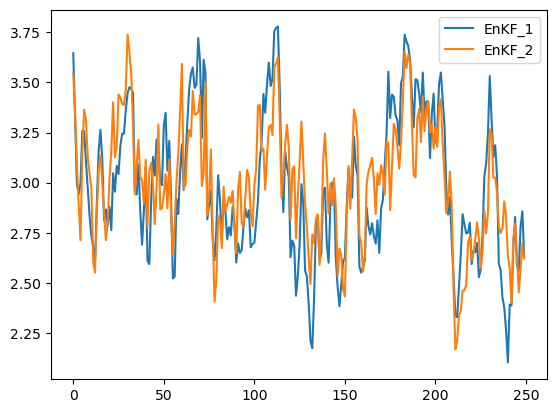

In [179]:
runDA(f2)
runDA(f3)
plt.plot(f2.rmse, label = f2.exptname)
plt.plot(f3.rmse, label = f3.exptname)
plt.legend()

In [ ]:
#f1 = Expt('Stochastic EnKF', {'expt_flag': 2, 'T': 250, 'model_flag': 0, 'Ne':5, 'dt':0.001, 'sig_y': 1})
f2 = Expt('EnKF_roi005', {'expt_flag': 0, 'T': 150, 'model_flag': 1, 'Ne':15, 'dt': 0.05, 'sig_y': 1, 'roi_kf': 0.01, 'obf': 10, 'doSV':True, 'stepSV' : 3})
#f3 = Expt('EnKF_roi01', {'expt_flag': 0, 'T': 250, 'model_flag': 1, 'Ne':15, 'dt': 0.01, 'sig_y': 1,  'roi_kf': 0.01, 'obf': 7})

In [145]:
#Run a series of experiments changing the Ensemble size
def_params = {'expt_flag': 0, 'T': 150, 'model_flag': 1, 'dt': 0.05, 'sig_y': 1, 'roi_kf': 0.001, 'obf': 10, 'doSV': True, 'stepSV' : 3}
Ne_steps = np.arange(10, 55, 5)
expt_list = []
for i, ne in enumerate(Ne_steps):
      def_params['Ne'] = ne
      e = Expt('EnKF_SVdt_4_Ne_{}'.format(ne), def_params)
      if i != 0:
            e.copyStates(expt_list[0])
      expt_list.append(e)

In [146]:
for e in expt_list:
      runDA(e)

In [147]:
#Run a series of experiments changing the forecastSV size
def_params = {'expt_flag': 0, 'T': 150, 'model_flag': 1, 'dt': 0.05,  'Ne': 30, 'sig_y': 1, 'roi_kf': 0.001, 'obf': 10, 'doSV': True, 'stepSV' : 3}
forecastStep = [3, 4, 5, 6, 7, 8]
expt_list = []
for n in forecastStep:
      def_params['forecastSV'] = n
      expt_list.append(Expt('EnKF_diffSVdt_{}'.format(n), def_params))

for e in expt_list:
      runDA(e)

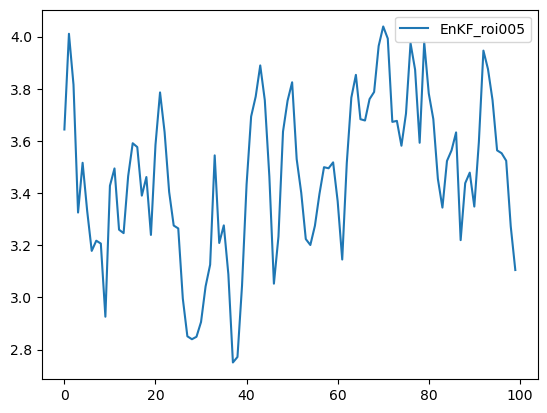

In [130]:
#f3.copyStates(f2)
#f3 = Expt('PF', {'expt_flag': 1, 'T': 250, 'model_flag': 0, 'Ne':15, 'dt':0.001})
#runDA(f1)
runDA(f2)
#runDA(f3)

#plt.plot(f1.rmse, label = f1.exptname)
plt.plot(f2.rmse, label = f2.exptname)
#plt.plot(f3.rmse, label = f3.exptname)
plt.legend()

In [131]:
test = xr.open_dataset('./SVs/SV_EnKF_roi005.cdf')

In [110]:
test.close()

In [126]:
svi = test['initial'].isel(t = 10).values
sve = test['evolved'].isel(t = 10).values

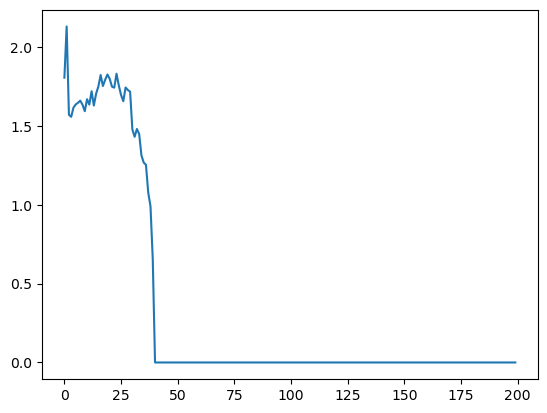

In [132]:
plt.plot(test['energy'].mean(dim='t'))

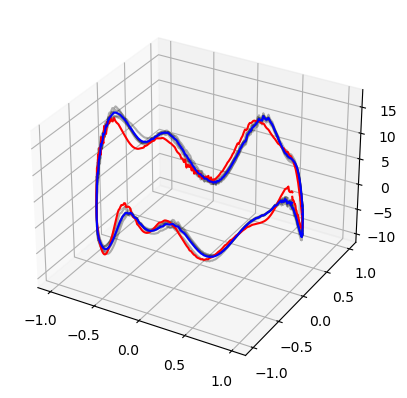

In [ ]:
r = 1
Nx = f2.getParam('Nx')
Ne = f2.getParam('Ne')
Nt = f2.getParam('T')
H = f2.getParam('H')
xf, xt, Y = f2.getStates()
x_ens = f2.x_ens
ensmin, ensmax = np.min(x_ens[:, :, 10:]), np.max(x_ens[:, :, 10:])
ts = np.linspace(0, 2*np.pi, Nx)
xs, ys = r*np.cos(ts), r*np.sin(ts)
hxs, hys = np.matmul(H, xs[:, np.newaxis])[:, 0], np.matmul(H, ys[:, np.newaxis])[:, 0]
i = 0
for t in range(10, Nt):
      plt.close()
      fig = plt.figure()
      ax = plt.axes(projection = '3d')
      #ax.plot3D(xs, ys, 0, ls = 'dashed')
      #ax.scatter3D(xs, ys, xt[:, t])
      for n in range(Ne):
            ax.plot3D(xs, ys,  x_ens[:, n, t], 'black', alpha = 0.3)
      ax.plot3D(xs, ys, xt[:, t], 'red')
      ax.plot3D(xs, ys, np.mean(x_ens[:, :, t], axis = 1), 'blue')
      #ax.scatter3D(hxs, hys, Y[:, t, 0], 'red')
      ax.set_zlim((ensmin, ensmax))
      fig.savefig('./anims/frame_{:03d}.png'.format(i))
      i = i+1
